In [1]:
import os
import re
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools
import math
from copy import deepcopy

from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
from sklearn.metrics import confusion_matrix
from autocatalytic_cores_lib import *
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sympy import symbols, Matrix, diff, lambdify
from scipy.linalg import eigvals

In [42]:
# create output path
output_dir = "output_1"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile = os.path.join(output_dir, f"AC_n{n}.xlsx")
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def compute_mu(mu0, R, T, Z):
    
    if Z <= 0:
        raise ValueError
    
    return mu0 + R * T * math.log(Z)

def Single_Invasion(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        #resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        #resAff = open(os.path.join(output_dir, f"Affinity_{r + 1}.dat"), "w")
        #resY.truncate(0)
        resSp.truncate(0)
        #resAff.truncate(0)
        

        # Define physics parameter
        R = 1
        T = 1
        
        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        print(f"X concentration = {X}")
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        #Solvent = 10        #Solvent concentration
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        # confine the chemical potentials of species X
        mu_0_X = [random.uniform(-1, 1) for _ in range(N_X)]
        mu_0_Y = [random.uniform(-1, 1) for _ in range(N_Y)]
        mu_0 = mu_0_X + mu_0_Y
        print(f"mu_0={mu_0}")

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        print(f"DeltaG0={DeltaG0}")
        print(f"kr/kf:{np.exp(DeltaG0)}")
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []

        def dydt(t, Y):
            nonlocal X_values
            # nonlocal Aff_values
            
            X_values.append(X.copy()) # record X
            # Aff = np.zeros(N_RY) # record Affinity
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
        
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values)
        # print(f"X_values.shape: {X_values.shape}")
        # print(f"X concentration: {X_values}")

        columns = ['Time'] + [f"Y_{i+1}" for i in range(N_Y)]
        df_y = pd.DataFrame(np.column_stack((sol.t, sol.y.T)), columns=columns)
        print(df_y.head)
        file_path = os.path.join(output_dir, f"Time_{r + 1}.dat")
        df_y.to_csv(file_path, sep=" ", index = False, header = True)

        Aff_values = []
        Chem_work = []
        Entropy_prod_rate = []
        
        for Y_vec in sol.y.T:  # iterate over solution at each time in sol.t
            X_Y = np.concatenate((X, Y_vec))
            Aff = np.zeros(N_RY)
            curr2 = np.zeros(N_RY)
            ratef2 = np.ones(len(kf)) if law == "MM" else kf[:]
            rater2 = deepcopy(kr)
            # Compute affinity and chemical work for each reaction using the same formula as in dydt
            for l in range(N_RY):
                # Forward and reverse rates for this reaction at the current state
                prod = 1.0
                for s, p in zip(X_Y, S[:, l]):
                    prod *= s**p
                if law == "MM":
                    ratef2[l] = prod / (kf[l] + prod)
                else:
                    ratef2[l] = kf[l] * prod
                rater2[l] = kr[l]
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = s**p
                    if prod_term > 1e10:
                        prod_term = 1e10
                    rater2[l] *= prod_term

                # Safe subtraction with check for NaN or Inf
                curr2[l] = ratef2[l] - rater2[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr2[l]) or np.isinf(curr2[l]):
                    curr2[l] = 0.0

                # Affinity calculation
                if rater2[l] != 0 and ratef2[l] >= 0:
                    Aff[l] = np.log(ratef2[l] / rater2[l])
                else:
                    Aff[l] = np.nan

            #Chemical work calculation
            Curr_ext = np.zeros(N_X)
            for i in range(N_X):
                Curr_ext[i] = - np.dot(Stot[i, :], curr2)
            Ztot = sum(X) + sum(Y_vec)
            mu_X_actual = np.array([compute_mu(mu_0_X[i], R, T, X[i]) for i in range(N_X)])
            Work = np.dot(mu_X_actual, Curr_ext)

            # Entropy Production Rate calculation
            EP_rate = np.dot(curr2, Aff)
            
            Entropy_prod_rate.append(EP_rate)
            Chem_work.append(Work.copy())
            Aff_values.append(Aff.copy())
        Aff_values = np.array(Aff_values)
        Chem_work = np.array(Chem_work)
        Entropy_prod_rate = np.array(Entropy_prod_rate)

        columns = ['Time'] + ['Chemwork']
        df_Chemwork = pd.DataFrame(np.column_stack((sol.t, Chem_work)), columns=columns)
        print(df_Chemwork.head)
        file_path = os.path.join(output_dir, f"Chemwork.dat")
        df_Chemwork.to_csv(file_path, sep=" ", index=False, header=True)

        columns = ['Time'] + ['EP_Rate']
        df_EP_rate = pd.DataFrame(np.column_stack((sol.t, Entropy_prod_rate)), columns=columns)
        print(df_EP_rate.head)
        file_path = os.path.join(output_dir, f"Entropy_Production_Rate.dat")
        df_EP_rate.to_csv(file_path, sep=" ", index=False, header=True)

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        '''
        # Write the full time series of Single Y species
        for t, y_values in zip(sol.t, sol.y.T):
            resY.write(f"{t:.3f}" +",".join(f"{y:.3f}" for y in y_values) + "\n")

        # Write the full time series of Affinity in each reaction
        for t, aff_values in zip(sol.t, Aff_values):
            resAff.write(f"{t:.3f}," + ",".join(f"{aff:.3f}" for aff in aff_values) + "\n")
        '''
        columns = ['Time'] + [f"Aff_{i+1}" for i in range(N_RY)]
        df_Aff = pd.DataFrame(np.column_stack((sol.t, Aff_values)), columns=columns)
        print(df_Aff.head)
        file_path = os.path.join(output_dir, f"Aff_{r + 1}.dat")
        df_Aff.to_csv(file_path, sep=" ", index=False, header=True)
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        #resY.close()
        #resAff.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival

In [39]:
# Define parameters
ttot5 = 200.0  # Total simulation time
dt5 = 1.0E-3  # Timestep
REALIZATIONS5 = 1  # Number of simulation runs
N_X5 = 15  # Number of original species
N_Y5 = 15  # Number of invaders
N_RY5 = 20  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_0 = Single_Invasion(N_X = N_X5, N_Y = N_Y5, N_RY = N_RY5, ttot = ttot5, dt = dt5, REALIZATIONS = REALIZATIONS5, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

X concentration = [2.001471264984465, 1.9855041708084036, 1.9701849026884999, 2.0154281418088917, 1.92787189763647, 1.9951697577656322, 1.9842848288769404, 2.0124936404551206, 1.945355565367563, 2.003216470958145]
mu_0=[-0.4587789558150692, 0.11488579053190517, 0.939446737059104, 0.9170604283909247, 0.4545627677283899, 0.7761487064041679, 0.5767256291105196, -0.41910595975996934, 0.43772810597318323, 0.1928616395214522, 0.3895759242986596, 0.13490920939862172, 0.2657043577582685, 0.9536809114683154, -0.5958999743525428, 0.3790528188254434, 0.09425214975411245, -0.5496749869889035, 0.967157592275814, 0.6078905156353414, 0.007001424545901136, -0.3386243545807337, 0.5623440656993011, -0.8156380011799316, 0.5304397829861178]
DeltaG0=[ 0.96034746  0.2288377   0.17145221 -1.10506788  0.2881535   0.2187973
  0.18329125  0.45625288 -0.96795137  0.08545563 -1.4365771   1.1575655
  1.10953834  0.60856905  0.21105063  0.36252528  0.56791123 -0.12481971
  0.55563209 -0.29219964]
kr/kf:[2.61260409 

    Time       Y_1       Y_2       Y_3       Y_4       Y_5       Y_6  \
0  0.000  0.009748  0.010139  0.009823  0.009713  0.009501  0.010477   
1  0.001  0.009712  0.010139  0.009925  0.009720  0.009532  0.010406   
2  0.002  0.009677  0.010139  0.010027  0.009726  0.009562  0.010335   
3  0.003  0.009641  0.010139  0.010128  0.009733  0.009593  0.010264   
4  0.004  0.009609  0.010139  0.010227  0.009739  0.009622  0.010196   

        Y_7       Y_8       Y_9      Y_10      Y_11      Y_12      Y_13  \
0  0.009959  0.009764  0.009667  0.009861  0.010233  0.010111  0.009886   
1  0.010022  0.009818  0.009706  0.009758  0.010233  0.010090  0.009891   
2  0.010085  0.009871  0.009745  0.009655  0.010234  0.010070  0.009896   
3  0.010148  0.009924  0.009784  0.009551  0.010234  0.010050  0.009902   
4  0.010209  0.009974  0.009823  0.009451  0.010234  0.010030  0.009907   

       Y_14      Y_15  
0  0.009839  0.009983  
1  0.009906  0.010010  
2  0.009974  0.010037  
3  0.010042  0.01006

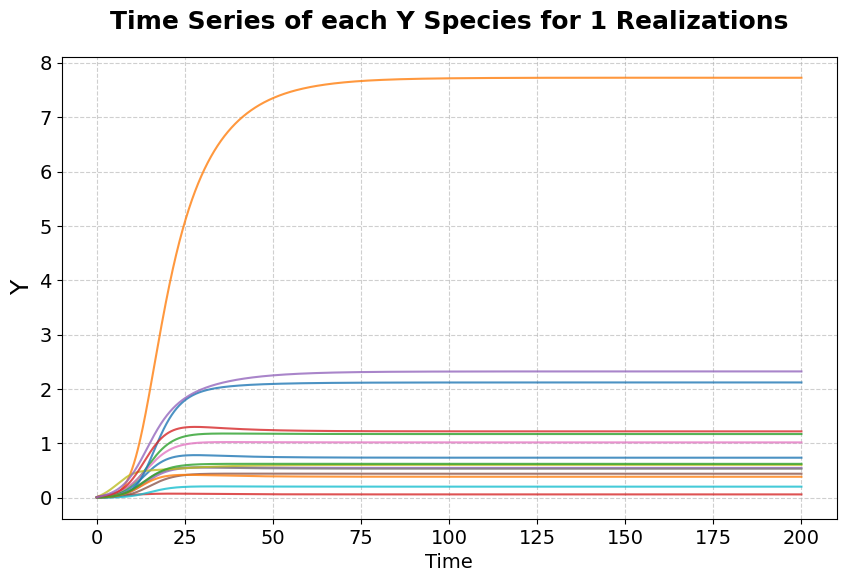

In [40]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)
        
# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

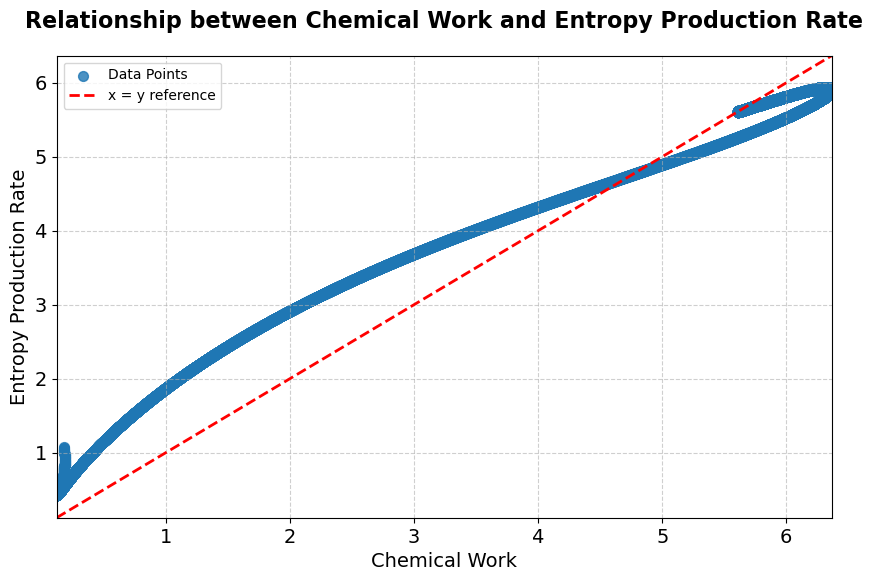

In [41]:
# Plot Entropy Production Rate versus Chemical Work

folder_path = output_dir

ep_file = os.path.join(folder_path, "Entropy_Production_Rate.dat")
work_file = os.path.join(folder_path, "Chemwork.dat")

# read file
df_ep = pd.read_csv(ep_file, sep=' ')
df_work = pd.read_csv(work_file, sep=' ')

# merge data
df_merged = pd.merge(df_ep, df_work, on='Time')

# set the same range for x and y axis
min_val = min(df_merged['Chemwork'].min(), df_merged['EP_Rate'].min())
max_val = max(df_merged['Chemwork'].max(), df_merged['EP_Rate'].max())

plt.figure(figsize=(10, 6))
plt.scatter(df_merged['Chemwork'], df_merged['EP_Rate'], s=50, alpha=0.8, label='Data Points')

plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Add x = y reference line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='x = y reference')

plt.xlabel('Chemical Work', fontsize=14)
plt.ylabel('Entropy Production Rate', fontsize=14)
plt.title('Relationship between Chemical Work and Entropy Production Rate', fontsize=16, pad=20, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

os.makedirs("./output/images", exist_ok=True)
plt.savefig("./output/images/EP_vs_Chemwork_same_range.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# Define parameters
ttot1 = 200.0  # Total simulation time
dt1 = 1.0E-3  # Timestep
REALIZATIONS1 = 1  # Number of simulation runs
N_X1 = 25  # Number of original species
N_Y1 = 25  # Number of invaders
N_RY1 = 50  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_1 = Single_Invasion(N_X = N_X1, N_Y = N_Y1, N_RY = N_RY1, ttot = ttot1, dt = dt1, REALIZATIONS = REALIZATIONS1, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

X concentration = [1.9637994153015765, 2.0582598528543494, 1.9182037703647938, 2.013284417595602, 2.048805027753657, 1.993932476124781, 2.060698506998642, 1.9134669139235043, 2.059949500513261, 1.9914242328574796, 1.9102574865832653, 1.9636546193748123, 1.975349887976408, 1.926982735363838, 1.97868787274783, 2.0281846641641104, 2.0726672235602543, 2.042372154520759, 2.0986484373353127, 2.047463420053119, 1.9187461528888883, 1.9133420300300483, 1.9737986903744618, 1.9598415864433876, 1.913534381240653]
mu_0=[-0.42670622702206895, -0.3019326852057156, 0.44700333912843315, 0.1261696977066451, -0.6658545127570887, 0.871567904598542, 0.751253630332932, -0.6209975169636355, 0.030983824798829218, -0.10996840881191927, 0.3669745440934591, -0.4423809260200233, -0.9011627937383486, -0.5288493459314547, -0.3604647091436046, -0.32888566396620367, 0.06730836882721425, -0.3991895964921104, -0.11066439923506732, 0.22032939915485183, 0.47395586171836435, -0.5484995322845607, -0.6430678089882944, -0.59

    Time       Y_1       Y_2       Y_3       Y_4       Y_5       Y_6  \
0  0.000  0.009997  0.010359  0.010029  0.009594  0.009642  0.009510   
1  0.001  0.009759  0.010411  0.009965  0.009658  0.010090  0.009489   
2  0.002  0.009527  0.010461  0.009901  0.009721  0.010528  0.009467   
3  0.003  0.009304  0.010510  0.009839  0.009784  0.010955  0.009445   
4  0.004  0.009089  0.010557  0.009777  0.009847  0.011368  0.009422   

        Y_7       Y_8       Y_9  ...      Y_16      Y_17      Y_18      Y_19  \
0  0.009682  0.009534  0.009935  ...  0.010194  0.009634  0.009894  0.009919   
1  0.009843  0.009520  0.009960  ...  0.010443  0.009650  0.009933  0.009703   
2  0.010001  0.009507  0.009985  ...  0.010687  0.009664  0.009972  0.009490   
3  0.010156  0.009494  0.010009  ...  0.010923  0.009676  0.010012  0.009281   
4  0.010307  0.009482  0.010034  ...  0.011151  0.009687  0.010051  0.009078   

       Y_20      Y_21      Y_22      Y_23      Y_24      Y_25  
0  0.009590  0.009933 

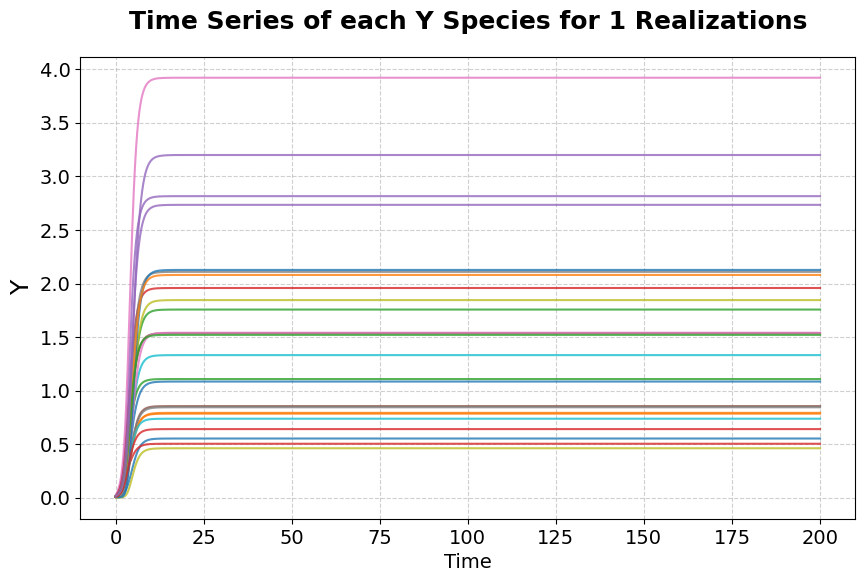

In [45]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)
        
# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

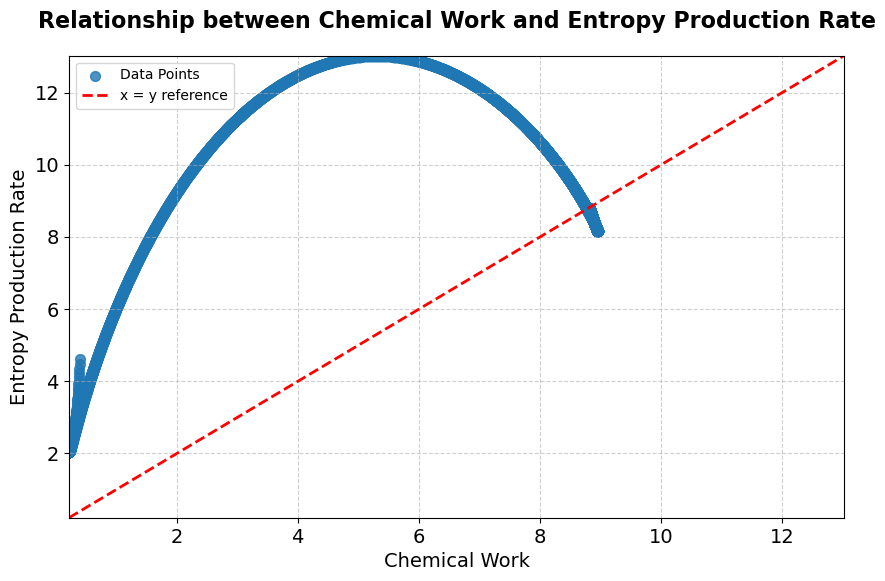

In [44]:
# Plot Entropy Production Rate versus Chemical Work

folder_path = output_dir

ep_file = os.path.join(folder_path, "Entropy_Production_Rate.dat")
work_file = os.path.join(folder_path, "Chemwork.dat")

# read file
df_ep = pd.read_csv(ep_file, sep=' ')
df_work = pd.read_csv(work_file, sep=' ')

# merge data
df_merged = pd.merge(df_ep, df_work, on='Time')

# set the same range for x and y axis
min_val = min(df_merged['Chemwork'].min(), df_merged['EP_Rate'].min())
max_val = max(df_merged['Chemwork'].max(), df_merged['EP_Rate'].max())

plt.figure(figsize=(10, 6))
plt.scatter(df_merged['Chemwork'], df_merged['EP_Rate'], s=50, alpha=0.8, label='Data Points')

plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Add x = y reference line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='x = y reference')

plt.xlabel('Chemical Work', fontsize=14)
plt.ylabel('Entropy Production Rate', fontsize=14)
plt.title('Relationship between Chemical Work and Entropy Production Rate', fontsize=16, pad=20, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

os.makedirs("./output/images", exist_ok=True)
plt.savefig("./output/images/EP_vs_Chemwork_same_range.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Try to Realize it in multiple realizations 

# Now we want to try to study the dissapation rate of cores and energy flows of different reactions  

Based on "Horowitz, Jordan M., and Jeremy L. England. "Spontaneous fine-tuning to environment in many-species chemical reaction networks." Proceedings of the National Academy of Sciences 114, no. 29 (2017): 7565-7570." we can define the energy flow of a reaction as Current * Affnity, it's similar to the decomposition of the notion of entropy production rate, that shows the reaction with the largest dissipation rate.

In [34]:
# create output path
output_dir = "output_2"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile = os.path.join(output_dir, f"AC_n{n}.xlsx")
    #txtfile="output/AC_n%d.txt"%(n)
    
    ac_df = ComputeAutocatalyticCores(SM, Excelfile)
    return ac_df

def count_reaction_participation(ac_df, threshold=0.001):
    """
    Count the number of times each reaction (column name starts with "X") participates in MAS directly from ac_df.
    The participation condition is that the flux of the reaction is greater than the threshold.
    Return a Series with the index as the reaction column name and the value as the number of participations.
    """
    reaction_columns = [col for col in ac_df.columns if col.startswith('X')]
    reaction_counts = ac_df[reaction_columns].apply(lambda x: (x > threshold).sum())
    return reaction_counts

def compute_mu(mu0, R, T, Z):
    
    if Z <= 0:
        raise ValueError
    
    return mu0 + R * T * math.log(Z)

def Single_Invasion(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    reaction_participation_all = {}

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        #resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        #resAff = open(os.path.join(output_dir, f"Affinity_{r + 1}.dat"), "w")
        #resY.truncate(0)
        resSp.truncate(0)
        #resAff.truncate(0)
        

        # Define physics parameter
        R = 1
        T = 1
        
        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        print(f"X concentration = {X}")
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        #Solvent = 10        #Solvent concentration
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        # confine the chemical potentials of species X
        mu_0_X = [random.uniform(-1, 1) for _ in range(N_X)]
        mu_0_Y = [random.uniform(-1, 1) for _ in range(N_Y)]
        mu_0 = mu_0_X + mu_0_Y
        print(f"mu_0={mu_0}")

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        print(f"DeltaG0={DeltaG0}")
        print(f"kr/kf:{np.exp(DeltaG0)}")
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        ac_df = auto(Stot,N_Y)

        reaction_counts = count_reaction_participation(ac_df)
        reaction_counts.to_csv(os.path.join(output_dir, "Reaction_Participation.csv"), index=True)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []

        def dydt(t, Y):
            nonlocal X_values
            # nonlocal Aff_values
            
            X_values.append(X.copy()) # record X
            # Aff = np.zeros(N_RY) # record Affinity
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
        
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values)
        # print(f"X_values.shape: {X_values.shape}")
        # print(f"X concentration: {X_values}")

        columns = ['Time'] + [f"Y_{i+1}" for i in range(N_Y)]
        df_y = pd.DataFrame(np.column_stack((sol.t, sol.y.T)), columns=columns)
        print(df_y.head)
        file_path = os.path.join(output_dir, f"Time_{r + 1}.dat")
        df_y.to_csv(file_path, sep=" ", index = False, header = True)

        Aff_values = []
        Chem_work = []
        Entropy_prod_rate = []
        Energy_Flow = []
        
        for Y_vec in sol.y.T:  # iterate over solution at each time in sol.t
            X_Y = np.concatenate((X, Y_vec))
            Aff = np.zeros(N_RY)
            curr2 = np.zeros(N_RY)
            ratef2 = np.ones(len(kf)) if law == "MM" else kf[:]
            rater2 = deepcopy(kr)
            # Compute affinity and chemical work for each reaction using the same formula as in dydt
            for l in range(N_RY):
                # Forward and reverse rates for this reaction at the current state
                prod = 1.0
                for s, p in zip(X_Y, S[:, l]):
                    prod *= s**p
                if law == "MM":
                    ratef2[l] = prod / (kf[l] + prod)
                else:
                    ratef2[l] = kf[l] * prod
                rater2[l] = kr[l]
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = s**p
                    if prod_term > 1e10:
                        prod_term = 1e10
                    rater2[l] *= prod_term

                # Safe subtraction with check for NaN or Inf
                curr2[l] = ratef2[l] - rater2[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr2[l]) or np.isinf(curr2[l]):
                    curr2[l] = 0.0

                # Affinity calculation
                if rater2[l] != 0 and ratef2[l] >= 0:
                    Aff[l] = np.log(ratef2[l] / rater2[l])
                else:
                    Aff[l] = np.nan
            
            E_Flow = curr2 * Aff
            Energy_Flow.append(E_Flow.copy())

            #Chemical work calculation
            Curr_ext = np.zeros(N_X)
            for i in range(N_X):
                Curr_ext[i] = - np.dot(Stot[i, :], curr2)
            Ztot = sum(X) + sum(Y_vec)
            mu_X_actual = np.array([compute_mu(mu_0_X[i], R, T, X[i]) for i in range(N_X)])
            Work = np.dot(mu_X_actual, Curr_ext)

            # Entropy Production Rate calculation
            EP_rate = np.dot(curr2, Aff)
            
            Entropy_prod_rate.append(EP_rate)
            Chem_work.append(Work.copy())
            Aff_values.append(Aff.copy())
        Aff_values = np.array(Aff_values)
        Chem_work = np.array(Chem_work)
        Entropy_prod_rate = np.array(Entropy_prod_rate)
        Energy_Flow = np.array(Energy_Flow)

        columns = ['Time'] + ['Chemwork']
        df_Chemwork = pd.DataFrame(np.column_stack((sol.t, Chem_work)), columns=columns)
        print(df_Chemwork.head)
        file_path = os.path.join(output_dir, f"Chemwork.dat")
        df_Chemwork.to_csv(file_path, sep=" ", index=False, header=True)

        columns = ['Time'] + ['EP_Rate']
        df_EP_rate = pd.DataFrame(np.column_stack((sol.t, Entropy_prod_rate)), columns=columns)
        print(df_EP_rate.head)
        file_path = os.path.join(output_dir, f"Entropy_Production_Rate.dat")
        df_EP_rate.to_csv(file_path, sep=" ", index=False, header=True)

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        '''
        # Write the full time series of Single Y species
        for t, y_values in zip(sol.t, sol.y.T):
            resY.write(f"{t:.3f}" +",".join(f"{y:.3f}" for y in y_values) + "\n")

        # Write the full time series of Affinity in each reaction
        for t, aff_values in zip(sol.t, Aff_values):
            resAff.write(f"{t:.3f}," + ",".join(f"{aff:.3f}" for aff in aff_values) + "\n")
        '''

        columns = ['Time'] + [f"Energy_Flow_{i+1}" for i in range(N_RY)]
        df_E_Flow = pd.DataFrame(np.column_stack((sol.t, Energy_Flow)), columns=columns)
        print(df_E_Flow.head)
        file_path = os.path.join(output_dir, f"Energy_Flow_{r + 1}.dat")
        df_E_Flow.to_csv(file_path, sep=" ", index=False, header=True)
        
        columns = ['Time'] + [f"Aff_{i+1}" for i in range(N_RY)]
        df_Aff = pd.DataFrame(np.column_stack((sol.t, Aff_values)), columns=columns)
        print(df_Aff.head)
        file_path = os.path.join(output_dir, f"Aff_{r + 1}.dat")
        df_Aff.to_csv(file_path, sep=" ", index=False, header=True)
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        #resY.close()
        #resAff.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival

In [47]:
# Define parameters
ttot1 = 200.0  # Total simulation time
dt1 = 1.0E-3  # Timestep
REALIZATIONS1 = 1  # Number of simulation runs
N_X1 = 3  # Number of original species
N_Y1 = 3  # Number of invaders
N_RY1 = 5  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_1 = Single_Invasion(N_X = N_X1, N_Y = N_Y1, N_RY = N_RY1, ttot = ttot1, dt = dt1, REALIZATIONS = REALIZATIONS1, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

X concentration = [2.0056220405392358, 2.0680191864748076, 1.9539574695559003]
mu_0=[-0.6640991558975451, 0.8491027047938129, 0.25457472660360825, -0.20459288715914803, 0.664613792397502, -0.39058679762523885]
DeltaG0=[-0.86920668 -1.14271904 -2.38240854  1.44578739 -1.32720795]
kr/kf:[0.41928404 0.3189506  0.09232793 4.24519344 0.26521673]
Matrix Stot 0:
   1  2  3  4  5
1  0  1  1  0  1
2  0  0 -1  0 -1
3  0  0  0  0  0
4  1  1  1  0  1
5 -1 -1 -1  1  0
6  0 -1  0 -2 -1
#Species:  6 # Reactions:  5
#Species:  6 # Reactions:  5
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output_3\AC_n3.xlsx
<bound method NDFrame.head of            Time        Y_1       Y_2       Y_3
0         0.000   0.009528  0.010032  0.010395
1         0.001   0.009598  0.009912  0.010542
2         0.002   0.009669  0.009791  0.010688
3         0.003   0.009739  0.009674  0.010832
4         0.004   0.009808  0.009557  0.010973
...         ...        ...       ..

    Time  Energy_Flow_1  Energy_Flow_2  Energy_Flow_3  Energy_Flow_4  \
0  0.000       0.011355       0.049870       0.094469       0.518887   
1  0.001       0.010838       0.050310       0.092428       0.509153   
2  0.002       0.010333       0.050756       0.090404       0.499523   
3  0.003       0.009848       0.051202       0.088440       0.490227   
4  0.004       0.009379       0.051652       0.086516       0.481153   

   Energy_Flow_5  
0       0.047610  
1       0.048606  
2       0.049604  
3       0.050573  
4       0.051526  


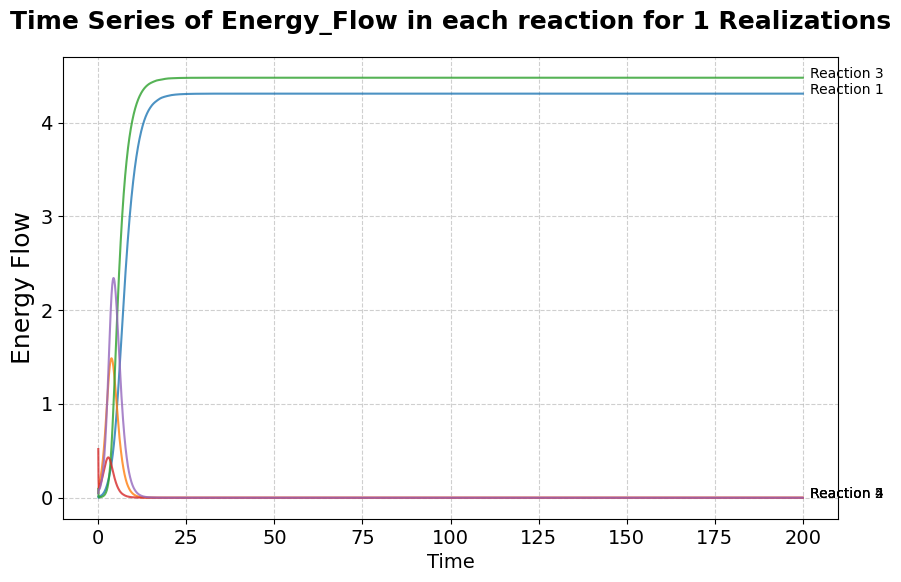

In [61]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Energy_Flow_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_Eflow = []

for file in file_list:
    data_Eflow = pd.read_csv(file, sep=' ', header=0)
    print(data_Eflow.head())
    time = data_Eflow['Time']
    for col in data_Eflow.columns:
        if col != 'Time':
            plt.plot(time, data_Eflow[col], linewidth=1.5, alpha=0.8, label=col)
            # Take the coordinates of the last data point as the annotation position
            x_last = time.iloc[-1]
            y_last = data_Eflow[col].iloc[-1]
            # Match Reaction Number
            match = re.search(r'\d+', col)
            reaction_number = match.group() if match else col
            # Add annotations
            plt.annotate(f'Reaction {reaction_number}', (x_last, y_last),
                         textcoords="offset points", xytext=(5, 0), ha='left', fontsize=10)
        

# Add title and labels
plt.title(f'Time Series of Energy_Flow in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy Flow', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Energy_Flow_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

    Time       Y_1       Y_2       Y_3
0  0.000  0.009528  0.010032  0.010395
1  0.001  0.009598  0.009912  0.010542
2  0.002  0.009669  0.009791  0.010688
3  0.003  0.009739  0.009674  0.010832
4  0.004  0.009808  0.009557  0.010973


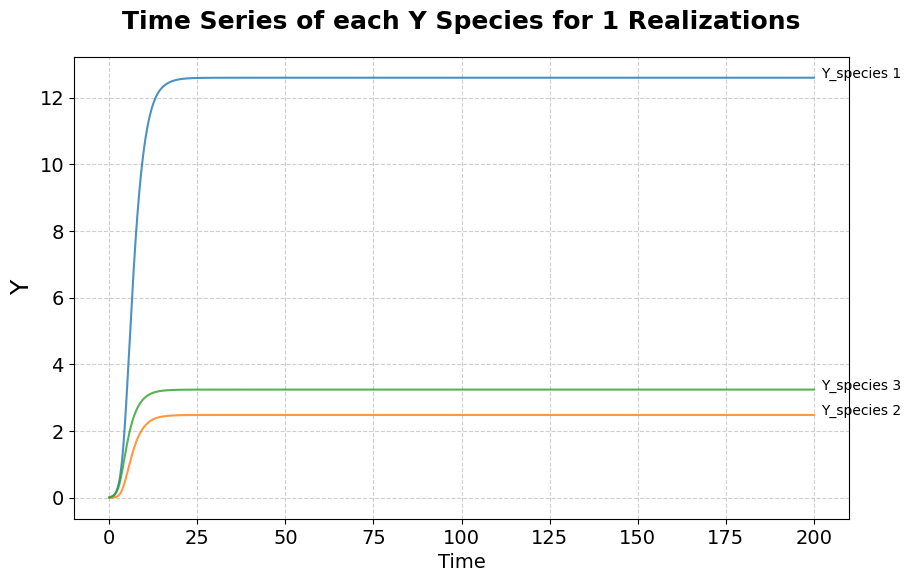

In [60]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)
            # Take the coordinates of the last data point as the annotation position
            x_last = time.iloc[-1]
            y_last = data_y[col].iloc[-1]
            # Match Reaction Number
            match = re.search(r'\d+', col)
            y_species_number = match.group() if match else col
            # Add annotations
            plt.annotate(f'Y_species {y_species_number}', (x_last, y_last),
                         textcoords="offset points", xytext=(5, 0), ha='left', fontsize=10)
        
# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

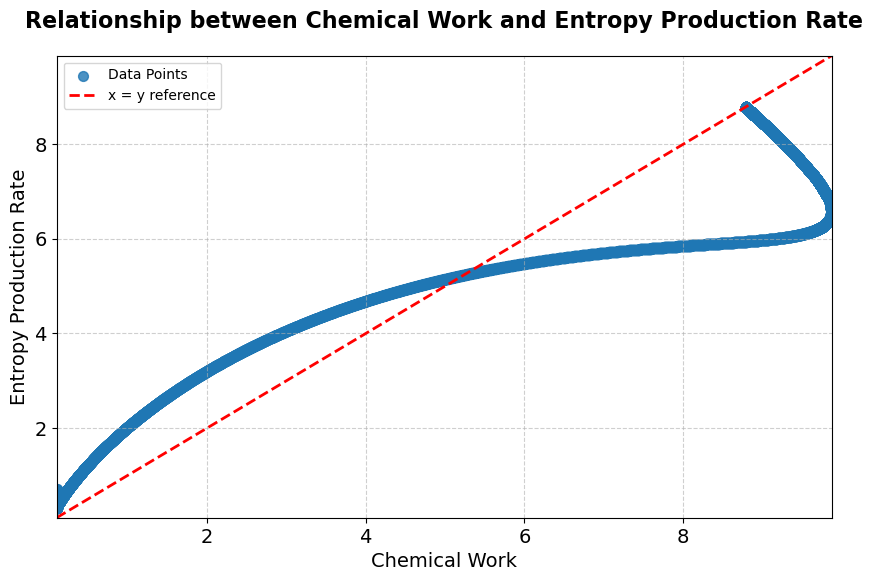

In [49]:
# Plot Entropy Production Rate versus Chemical Work

folder_path = output_dir

ep_file = os.path.join(folder_path, "Entropy_Production_Rate.dat")
work_file = os.path.join(folder_path, "Chemwork.dat")

# read file
df_ep = pd.read_csv(ep_file, sep=' ')
df_work = pd.read_csv(work_file, sep=' ')

# merge data
df_merged = pd.merge(df_ep, df_work, on='Time')

# set the same range for x and y axis
min_val = min(df_merged['Chemwork'].min(), df_merged['EP_Rate'].min())
max_val = max(df_merged['Chemwork'].max(), df_merged['EP_Rate'].max())

plt.figure(figsize=(10, 6))
plt.scatter(df_merged['Chemwork'], df_merged['EP_Rate'], s=50, alpha=0.8, label='Data Points')

plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Add x = y reference line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='x = y reference')

plt.xlabel('Chemical Work', fontsize=14)
plt.ylabel('Entropy Production Rate', fontsize=14)
plt.title('Relationship between Chemical Work and Entropy Production Rate', fontsize=16, pad=20, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

os.makedirs("./output/images", exist_ok=True)
plt.savefig("./output/images/EP_vs_Chemwork_same_range.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [35]:
# Define parameters
ttot1 = 200.0  # Total simulation time
dt1 = 1.0E-3  # Timestep
REALIZATIONS1 = 1  # Number of simulation runs
N_X1 = 10  # Number of original species
N_Y1 = 10  # Number of invaders
N_RY1 = 20  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_1 = Single_Invasion(N_X = N_X1, N_Y = N_Y1, N_RY = N_RY1, ttot = ttot1, dt = dt1, REALIZATIONS = REALIZATIONS1, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

X concentration = [2.0709178232844483, 2.048972130250851, 2.0657982837628057, 2.0208921771685766, 1.999766347768724, 2.0003186990366215, 2.053180163770241, 2.03563870846853, 2.073522233935819, 2.0369496667351976]
mu_0=[-0.6708699796612863, -0.5825042173390083, -0.9267740305051648, 0.07685886082207949, -0.5294119898341376, -0.9992907271406453, 0.061212822423124535, 0.8247064793230339, 0.911560709679061, 0.4638099956635573, -0.7358835112609812, -0.2602982969533556, -0.9010555215294564, -0.8890884765137022, -0.9556052237410393, 0.40080666471027726, -0.9172420220002591, -0.38183592643135533, 0.2871651883796569, 0.8869828244265947]
DeltaG0=[ 0.27559677  1.26881875 -1.03757929 -1.10364674  0.39112438  0.28130018
  0.5135289  -0.45182724 -0.70772997 -0.59981764 -1.91429066  1.014697
 -0.85701101  1.55556421 -0.5354061   1.5584548  -2.74364357 -0.23149693
  0.49173822  0.57811731]
kr/kf:[1.31731657 3.55664879 0.35431133 0.3316594  1.47864241 1.32485124
 1.67117822 0.63646411 0.49276151 0.54891

    Time  Energy_Flow_1  Energy_Flow_2  Energy_Flow_3  Energy_Flow_4  \
0  0.000       0.002640       0.061857       0.059381       0.000143   
1  0.001       0.002526       0.061326       0.059661       0.000145   
2  0.002       0.002416       0.060802       0.059924       0.000147   
3  0.003       0.002312       0.060287       0.060166       0.000149   
4  0.004       0.002210       0.059776       0.060398       0.000150   

   Energy_Flow_5  Energy_Flow_6  Energy_Flow_7  Energy_Flow_8  Energy_Flow_9  \
0       0.204014       0.297924       0.410674       0.001736       0.105376   
1       0.206162       0.296946       0.399555       0.001951       0.104378   
2       0.208251       0.295951       0.388681       0.002174       0.103406   
3       0.210278       0.294935       0.378063       0.002405       0.102458   
4       0.212269       0.293918       0.367608       0.002644       0.101529   

   ...  Energy_Flow_11  Energy_Flow_12  Energy_Flow_13  Energy_Flow_14  \
0  ...      

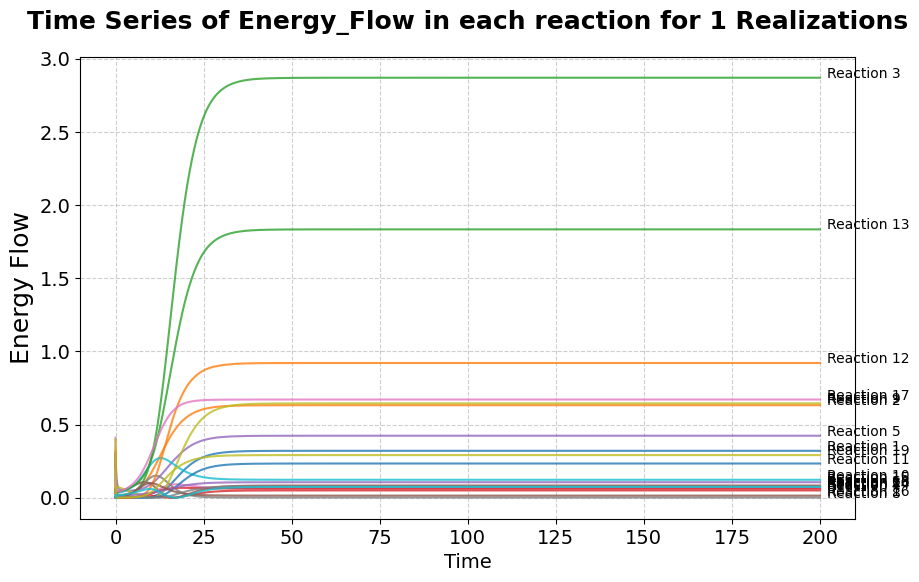

In [36]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Energy_Flow_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_Eflow = []

for file in file_list:
    data_Eflow = pd.read_csv(file, sep=' ', header=0)
    print(data_Eflow.head())
    time = data_Eflow['Time']
    for col in data_Eflow.columns:
        if col != 'Time':
            plt.plot(time, data_Eflow[col], linewidth=1.5, alpha=0.8, label=col)
            # Take the coordinates of the last data point as the annotation position
            x_last = time.iloc[-1]
            y_last = data_Eflow[col].iloc[-1]
            # Match Reaction Number
            match = re.search(r'\d+', col)
            reaction_number = match.group() if match else col
            # Add annotations
            plt.annotate(f'Reaction {reaction_number}', (x_last, y_last),
                         textcoords="offset points", xytext=(5, 0), ha='left', fontsize=10)
        

# Add title and labels
plt.title(f'Time Series of Energy_Flow in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy Flow', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Energy_Flow_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

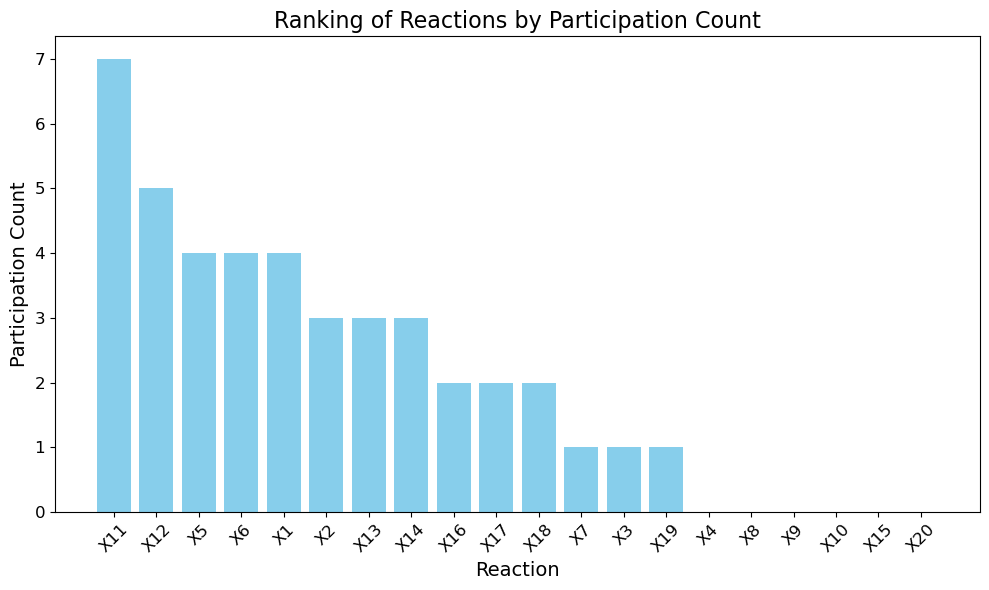

In [37]:
reaction_file = os.path.join(output_dir, "Reaction_Participation.csv")

df_react = pd.read_csv(reaction_file, index_col=0)

if "Participation_Count" not in df_react.columns:
    df_react.rename(columns={df_react.columns[0]: "Participation_Count"}, inplace=True)

# Sort in descending order
df_react_sorted = df_react.sort_values(by="Participation_Count", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(df_react_sorted.index, df_react_sorted["Participation_Count"], color='skyblue')
plt.xlabel("Reaction", fontsize=14)
plt.ylabel("Participation Count", fontsize=14)
plt.title("Ranking of Reactions by Participation Count", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

os.makedirs("./output/images", exist_ok=True)
plt.savefig("./output/images/Reaction_Participation_Ranking.pdf", dpi=300, bbox_inches='tight')
plt.show()


    Time       Y_1       Y_2       Y_3       Y_4       Y_5       Y_6  \
0  0.000  0.009838  0.009514  0.009971  0.010370  0.009801  0.010397   
1  0.001  0.009901  0.009554  0.010102  0.010561  0.009810  0.010167   
2  0.002  0.009964  0.009592  0.010231  0.010750  0.009819  0.009941   
3  0.003  0.010027  0.009630  0.010358  0.010937  0.009828  0.009719   
4  0.004  0.010091  0.009668  0.010483  0.011123  0.009838  0.009499   

        Y_7       Y_8       Y_9      Y_10  
0  0.010084  0.009896  0.009916  0.009739  
1  0.010044  0.009926  0.010109  0.009717  
2  0.010005  0.009955  0.010301  0.009695  
3  0.009967  0.009982  0.010491  0.009672  
4  0.009929  0.010008  0.010680  0.009649  


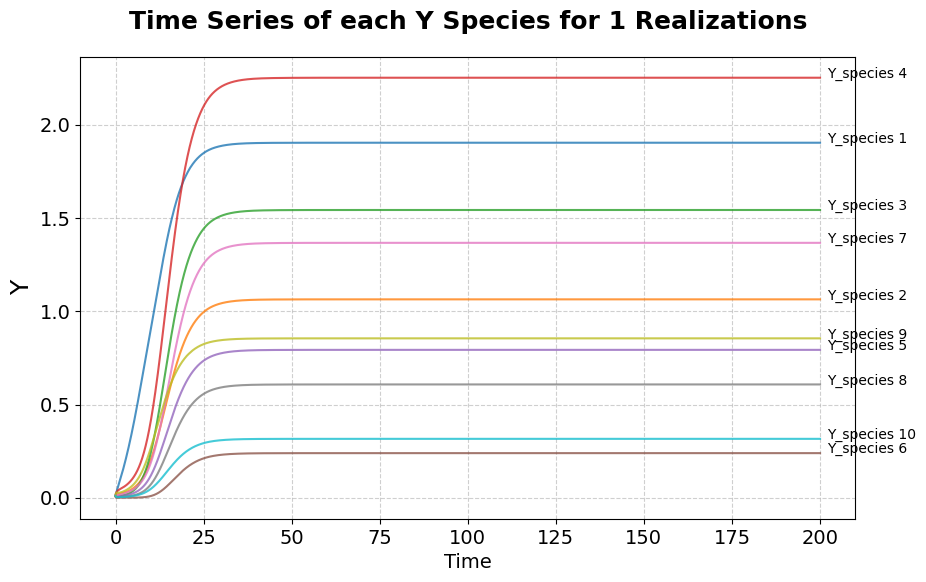

In [38]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
#file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
file_list.sort(key=lambda x: int(re.search(r'\d+', os.path.basename(x)).group()))

plt.figure(figsize=(10, 6))

data_y = []
for file in file_list:
    data_y = pd.read_csv(file, sep=' ', header=0)
    print(data_y.head())
    time = data_y['Time']
    for col in data_y.columns:
        if col != 'Time':
            plt.plot(time, data_y[col], linewidth=1.5, alpha=0.8, label=col)
            # Take the coordinates of the last data point as the annotation position
            x_last = time.iloc[-1]
            y_last = data_y[col].iloc[-1]
            # Match Reaction Number
            match = re.search(r'\d+', col)
            y_species_number = match.group() if match else col
            # Add annotations
            plt.annotate(f'Y_species {y_species_number}', (x_last, y_last),
                         textcoords="offset points", xytext=(5, 0), ha='left', fontsize=10)
        
# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Y', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

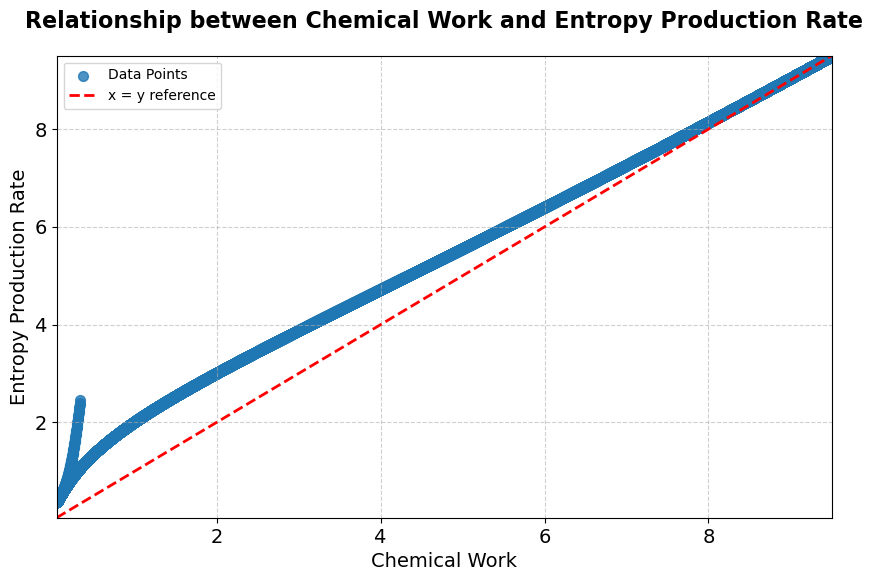

In [39]:
# Plot Entropy Production Rate versus Chemical Work

folder_path = output_dir

ep_file = os.path.join(folder_path, "Entropy_Production_Rate.dat")
work_file = os.path.join(folder_path, "Chemwork.dat")

# read file
df_ep = pd.read_csv(ep_file, sep=' ')
df_work = pd.read_csv(work_file, sep=' ')

# merge data
df_merged = pd.merge(df_ep, df_work, on='Time')

# set the same range for x and y axis
min_val = min(df_merged['Chemwork'].min(), df_merged['EP_Rate'].min())
max_val = max(df_merged['Chemwork'].max(), df_merged['EP_Rate'].max())

plt.figure(figsize=(10, 6))
plt.scatter(df_merged['Chemwork'], df_merged['EP_Rate'], s=50, alpha=0.8, label='Data Points')

plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Add x = y reference line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='x = y reference')

plt.xlabel('Chemical Work', fontsize=14)
plt.ylabel('Entropy Production Rate', fontsize=14)
plt.title('Relationship between Chemical Work and Entropy Production Rate', fontsize=16, pad=20, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

os.makedirs("./output/images", exist_ok=True)
plt.savefig("./output/images/EP_vs_Chemwork_same_range.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Clustering 
## Here, I think for clustering, we need to generate random chemical reaction network with different sizes, (under same condition?), and record the parameters that can distinguish dynamical growth (how to define?) and chemometrics growth (F-N growth rate?)

In [9]:
# create output path
output_dir = "output_clustering3"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y, realization_dir):
    n = N_Y
    Excelfile = os.path.join(realization_dir, f"AC_n{n}.xlsx")
    df = ComputeAutocatalyticCores(SM, Excelfile)
    num_ac = df.shape[0]
    return num_ac

def compute_mu(mu0, R, T, Z):
    
    if Z <= 0:
        raise ValueError
    
    return mu0 + R * T * math.log(Z)

def Cluster_Invasions(ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Define the network size range
    N_X_min, N_X_max = 3, 15     
    N_Y_min, N_Y_max = 3, 15   
    N_RY_min, N_RY_max = 4, 30  


    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Define physics parameter
    R = 1
    T = 1
        
    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Record Autocatalytic Cores and the success of invasion
    summary_records = []


    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        #resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        #resAff = open(os.path.join(output_dir, f"Affinity_{r + 1}.dat"), "w")
        #resY.truncate(0)
        resSp.truncate(0)
        #resAff.truncate(0)
        
        N_X = random.randint(N_X_min, N_X_max)
        N_Y = random.randint(N_Y_min, N_Y_max)
        N_RY = random.randint(N_RY_min, N_RY_max)

        # Creat folder for current realization
        realization_dir = os.path.join(output_dir, f"realization_{r+1}")
        os.makedirs(realization_dir, exist_ok=True)

        resSp = open(os.path.join(realization_dir, "Stoichio.dat"), "w")
        resSp.truncate(0)
        
        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        # confine the chemical potentials of species X
        mu_0_X = [random.uniform(-1, 1) for _ in range(N_X)]
        mu_0_Y = [random.uniform(-1, 1) for _ in range(N_Y)]
        mu_0 = mu_0_X + mu_0_Y
        
        # print(f"mu_0={mu_0}")

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        '''
        print(f"DeltaG0={DeltaG0}")
        print(f"kr/kf:{np.exp(DeltaG0)}")
        '''
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        df_S.to_csv(os.path.join(realization_dir, "Stoichiometric_Matrix.csv"), index=True)
        num_ac = auto(Stot, N_Y, realization_dir)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []

        def dydt(t, Y):
            nonlocal X_values
            # nonlocal Aff_values
            
            X_values.append(X.copy()) # record X
            # Aff = np.zeros(N_RY) # record Affinity
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
        
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values)
        # print(f"X_values.shape: {X_values.shape}")
        # print(f"X concentration: {X_values}")

        df_y = pd.DataFrame(np.column_stack((sol.t, sol.y.T)), 
                            columns=['Time'] + [f"Y_{i+1}" for i in range(N_Y)])
        df_y.to_csv(os.path.join(realization_dir, "Time.dat"), sep=" ", index=False, header=True)

        Aff_values = []
        Chem_work = []
        Entropy_prod_rate = []
        Energy_Flow = []
        
        for Y_vec in sol.y.T:  # iterate over solution at each time in sol.t
            X_Y = np.concatenate((X, Y_vec))
            Aff = np.zeros(N_RY)
            curr2 = np.zeros(N_RY)
            ratef2 = np.ones(len(kf)) if law == "MM" else kf[:]
            rater2 = deepcopy(kr)
            # Compute affinity and chemical work for each reaction using the same formula as in dydt
            for l in range(N_RY):
                # Forward and reverse rates for this reaction at the current state
                prod = 1.0
                for s, p in zip(X_Y, S[:, l]):
                    prod *= s**p
                if law == "MM":
                    ratef2[l] = prod / (kf[l] + prod)
                else:
                    ratef2[l] = kf[l] * prod
                rater2[l] = kr[l]
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = s**p
                    if prod_term > 1e10:
                        prod_term = 1e10
                    rater2[l] *= prod_term

                # Safe subtraction with check for NaN or Inf
                curr2[l] = ratef2[l] - rater2[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr2[l]) or np.isinf(curr2[l]):
                    curr2[l] = 0.0

                # Affinity calculation
                if rater2[l] != 0 and ratef2[l] >= 0:
                    Aff[l] = np.log(ratef2[l] / rater2[l])
                else:
                    Aff[l] = np.nan
            
            E_Flow = curr2 * Aff
            Energy_Flow.append(E_Flow.copy())

            #Chemical work calculation
            Curr_ext = np.zeros(N_X)
            for i in range(N_X):
                Curr_ext[i] = - np.dot(Stot[i, :], curr2)
            Ztot = sum(X) + sum(Y_vec)
            mu_X_actual = np.array([compute_mu(mu_0_X[i], R, T, X[i]) for i in range(N_X)])
            Work = np.dot(mu_X_actual, Curr_ext)

            # Entropy Production Rate calculation
            EP_rate = np.dot(curr2, Aff)
            
            Entropy_prod_rate.append(EP_rate)
            Chem_work.append(Work.copy())
            Aff_values.append(Aff.copy())
        Aff_values = np.array(Aff_values)
        Chem_work = np.array(Chem_work)
        Entropy_prod_rate = np.array(Entropy_prod_rate)
        Energy_Flow = np.array(Energy_Flow)


        df_Chemwork = pd.DataFrame(np.column_stack((sol.t, Chem_work)), 
                                   columns=['Time', 'Chemwork'])
        df_Chemwork.to_csv(os.path.join(realization_dir, "Chemwork.dat"), sep=" ", index=False, header=True)


        df_EP_rate = pd.DataFrame(np.column_stack((sol.t, Entropy_prod_rate)), 
                                  columns=['Time', 'EP_Rate'])
        df_EP_rate.to_csv(os.path.join(realization_dir, "Entropy_Production_Rate.dat"), sep=" ", index=False, header=True)


        df_E_Flow = pd.DataFrame(np.column_stack((sol.t, Energy_Flow)), 
                                 columns=['Time'] + [f"Energy_Flow_{i+1}" for i in range(N_RY)])
        df_E_Flow.to_csv(os.path.join(realization_dir, "Energy_Flow.dat"), sep=" ", index=False, header=True)
        

        df_Aff = pd.DataFrame(np.column_stack((sol.t, Aff_values)), 
                              columns=['Time'] + [f"Aff_{i+1}" for i in range(N_RY)])
        df_Aff.to_csv(os.path.join(realization_dir, "Aff.dat"), sep=" ", index=False, header=True)

        
        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")
        
        if sum(sol.y[:, -1]) >= 0.2:
            success = True
            compt += 1
            print("Invaded!!!")
        else:
            success = False
            print("NOT Invaded")

        # Save recording
        summary_records.append((r+1, num_ac, success))
        
        resSp.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    
    summary_df = pd.DataFrame(summary_records, 
                              columns=["Realization", "Autocatalytic_Core_Count", "Growth_Success"])
    summary_file = os.path.join(output_dir, "Summary.csv")
    summary_df.to_csv(summary_file, index=False)
    
    return survival

In [10]:
# Define parameters
ttot1 = 50.0  # Total simulation time
dt1 = 1.0E-3  # Timestep
REALIZATIONS1 = 20  # Number of simulation runs

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_1 = Cluster_Invasions(ttot = ttot1, dt = dt1, REALIZATIONS = REALIZATIONS1, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

#Species:  13 # Reactions:  10
#Species:  13 # Reactions:  10
Generating Autocatalytic Cycles...
**** Sol 1: 3 reactions
	 #Species:  3 #FoodSet:  1 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set ['C_2']
	 Waste Set ['C_5']
	 Extra M in AC:  []
	 Species in AC:  ['C_9', 'C_11', 'C_13']
	 Reactions in AC:  ['R1', 'R2', 'R10']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0]
			 R1: C_11 ->C_9+C_13
			 R2: C_2+C_13 ->C_5+C_11
			 R10: C_9 ->C_11
	 - CPU Time: 0.00 secs
**** Sol 2: 4 reactions
	 #Species:  4 #FoodSet:  1 #WasteSet:  1 #ExtraMembersSet:  1 #Reactions:  4
	 Food Set ['C_10']
	 Waste Set ['C_5']
	 Extra M in AC:  ['C_13']
	 Species in AC:  ['C_2', 'C_9', 'C_11', 'C_12']
	 Reactions in AC:  ['R2', 'R3', 'R4', 'R10']
	 Flow:  [] --> Production:  [0.0, 0.0, 0.0, 0.0]
			 R2: C_2+C_13 ->C_5+C_11
			 R3: C_10+C_11 ->C_9+C_12
			 R4: C_12 ->C_2+C_13
			 R10: C_9 ->C_11
	 - CPU Time: 0.01 secs
**** Sol 3: 4 reactions
	 #Species:  4 #FoodSet:  3 #WasteSet:  1 #ExtraMembers

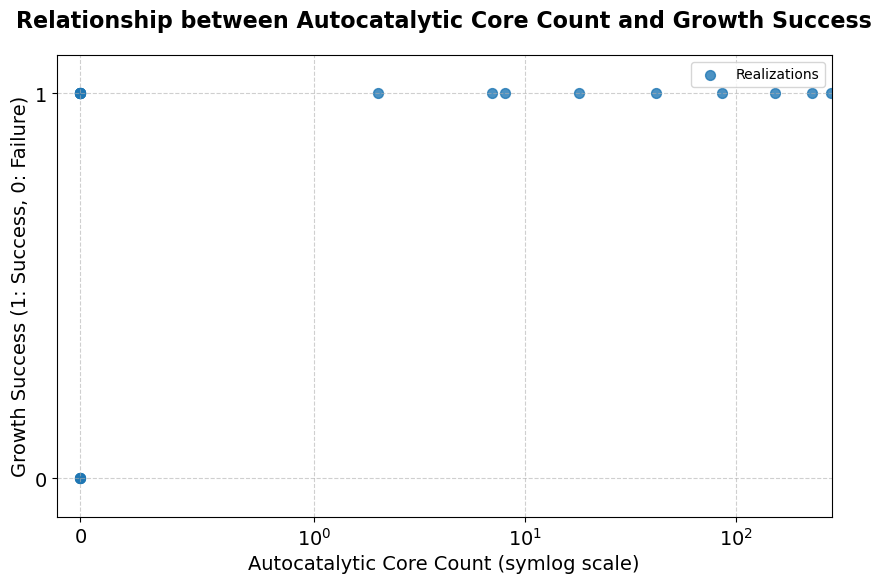

In [14]:
folder_path = output_dir
summary_file = os.path.join(folder_path, "Summary.csv")

df_summary = pd.read_csv(summary_file)

df_summary['Growth_Success_Int'] = df_summary['Growth_Success'].astype(int)

plt.figure(figsize=(10, 6))

# Display the x-axis using symlog coordinates, where the linthresh parameter specifies the size of the linear region around 0
plt.xscale('symlog', linthresh=1)

plt.scatter(df_summary['Autocatalytic_Core_Count'], df_summary['Growth_Success_Int'], 
            s=50, alpha=0.8, label='Realizations')

min_x = df_summary['Autocatalytic_Core_Count'].min()
max_x = df_summary['Autocatalytic_Core_Count'].max()
# Negative values ​​are acceptable in symlog coordinates, but if the data is mainly positive, the lower limit can be adjusted here
plt.xlim(min_x - 1 if min_x - 1 > 0 else -0.1, max_x + 1)
plt.ylim(-0.1, 1.1)

plt.xlabel('Autocatalytic Core Count (symlog scale)', fontsize=14)
plt.ylabel('Growth Success (1: Success, 0: Failure)', fontsize=14)
plt.title('Relationship between Autocatalytic Core Count and Growth Success', 
          fontsize=16, pad=20, weight='bold')
plt.xticks(fontsize=14)
plt.yticks([0, 1], fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

os.makedirs("./output/images", exist_ok=True)
plt.savefig("./output/images/ACCount_vs_GrowthSuccess_symlog.pdf", dpi=300, bbox_inches='tight')
plt.show()